# Imports and authentication
Import some packages for data handling and plotting. Also import datalab code.

In [1]:
# Python imports
import numpy as N
import pandas as pd
from cStringIO import StringIO
import pylab as p
import matplotlib
%matplotlib inline

# Datalab imports
from dl import authClient, queryClient

# authentication token; use it for all your queries below
token = authClient.login('anonymous')

# Get a list of SMASH fields
Let's get a sense of the SMASH field sky coverage. Select a list of all fields from the `field` table.
### Query the database

In [2]:
# query DB for a list of all SMASH fields
query = "SELECT ra,dec,nexp,nobj FROM smash_dr1.field WHERE nexp IS NOT NULL AND nobj IS NOT NULL"  # define sql query as a string
result = queryClient.query(token,adql=query,fmt='csv')  # submit the query, using your authentication token
print "Inspect the returned result: it's a csv-formatted string:"
print result[:105]

Inspect the returned result: it's a csv-formatted string:
ra,dec,nexp,nobj
103.81954,-36.918889,29,1751546
145.212,-26.9897,32,1538828
149.082,-27.9336,46,2313654



### Load columns into arrays
For easier handling, load the columns into arrays.

In [3]:
fi = StringIO(result)  # creates an in-RAM file (not on disk, just in RAM)
ra,dec,nexp,nobj = N.loadtxt(fi,unpack=True,skiprows=1,delimiter=',')  # reads columns from that 'file'

### Convert coordinates to radians, with wrap-around for RA

In [4]:
import astropy.units as u   # units module
from astropy.coordinates import SkyCoord

# use a helper, don't re-invent the wheel
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
ra = c.ra.wrap_at(180 * u.deg).radian  # ra and ...
dec = c.dec.radian                     # ... dec now in radians

### Plot all-sky map of SMASH field positions

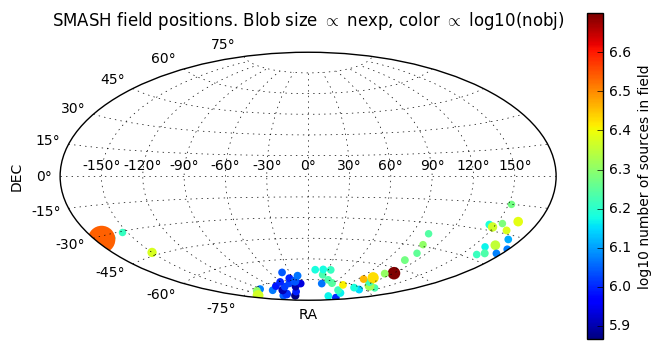

In [5]:
p.figure(figsize=(8,4.2))
p.subplot(111, projection="aitoff")
im = p.scatter(ra, dec, marker='o', s=nexp, c=N.log10(nobj), edgecolors='none',alpha=1)
cb = p.colorbar(im)
cb.set_label('log10 number of sources in field')
p.title(r"SMASH field positions. Blob size $\propto$ nexp, color $\propto$ log10(nobj)",y=1.08)
p.grid(True)
p.xlabel('RA')
p.ylabel('DEC')

# Average photometry of all objects in one field
Select from the `object` table all g and r mags of all sources in a single SMASH field. Apply some quality criteria. 

In [6]:
fieldID = 169 # a specific SMASH field
# note: the DB encodes 'no measurement' values as 99.99
query = "SELECT gmag,rmag FROM smash_dr1.object WHERE ABS(sharp)<0.5 AND fieldid=%d AND gmag<99 AND rmag<99" % fieldID
result = queryClient.query(token,adql=query,fmt='csv')  # query the DB

### Load results into a Pandas dataframe
The returned result is a long, csv-formatted string. Let's place it into a Pandas dataframe for easier access.

In [7]:
df = pd.read_csv(StringIO(result))
print df.columns  # lists the names of the columns in dataframe

Index([u'gmag', u'rmag'], dtype='object')


### Save to a CSV file
You can easily save the table to a csv file, for later use.

In [8]:
filename = 'smash_avg_photo_field%d.csv' % fieldID
df.to_csv(filename,index=False)  # don't write the index column

### Download the CSV file

In [9]:
# get the file size
import os
filesize = os.path.getsize(filename) / 1024.**2 # in MB

# display a download link
from IPython.display import HTML
HTML('<a href="%s">Click on this link to download file: %s (%.1f MB)</a>' % (filename,filename,filesize))

### Plot histograms and a color-magnitude diagram

(28, 13)

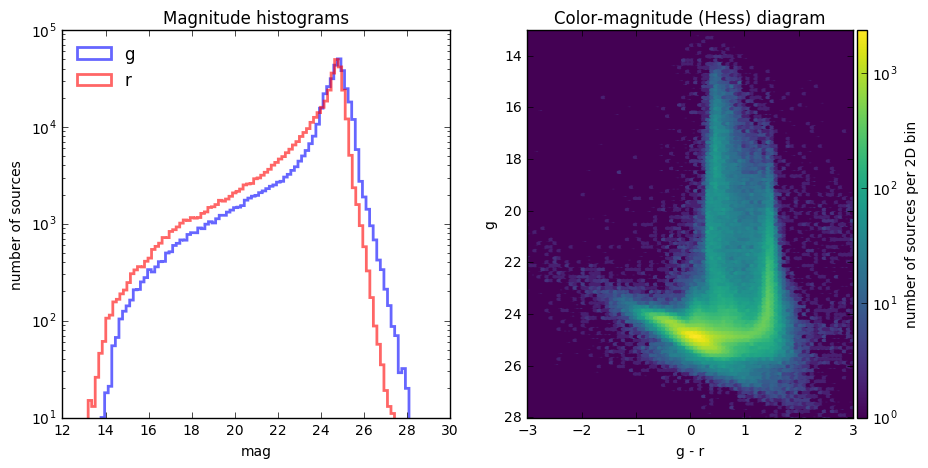

In [10]:
# make a figure
fig = p.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# mag histograms
ax1.hist(df['gmag'],bins=100,histtype='step',color='b',label='g',lw=2,alpha=0.6)
ax1.hist(df['rmag'],bins=100,histtype='step',color='r',label='r',lw=2,alpha=0.6)
ax1.set_yscale('log')
ax1.set_xlabel('mag')
ax1.set_ylabel('number of sources')
ax1.set_title('Magnitude histograms')
ax1.legend(loc='upper left',frameon=False)

# color-magnitude diagram (Hess diagram)
im = ax2.hexbin(df['gmag']-df['rmag'],df['gmag'],gridsize=200,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
cb = p.colorbar(im,aspect=40,pad=0.01)
cb.set_label('number of sources per 2D bin')
ax2.set_xlabel('g - r')
ax2.set_ylabel('g')
ax2.set_title('Color-magnitude (Hess) diagram')
ax2.set_xlim(-3,3)
ax2.set_ylim(28,13)

# Time-series photometry of a specific object

### Get lightcurves of one object
We can retrieve all calibrated magnitudes of a specific object, for all bands, and all epochs, from the `source` table.

In [11]:
objID = '169.429960' # this happens to be a RR Lyrae star in Hydra II
# select columns Julian date, calibrated mag, filter
# note: the DB encodes 'no measurement' values as 99.99
query = "SELECT mjd,cmag,filter FROM smash_dr1.source WHERE id='%s' AND cmag<99 ORDER BY mjd ASC" % objID
result = queryClient.query(token,adql=query,fmt='csv')  # run the query
df = pd.read_csv(StringIO(result))  # load to Pandas dataframe

### Plot light-curves per-band
Plot the light-curves of this source separately for every band. We also zoom in on a range of dates with interesting measurements.

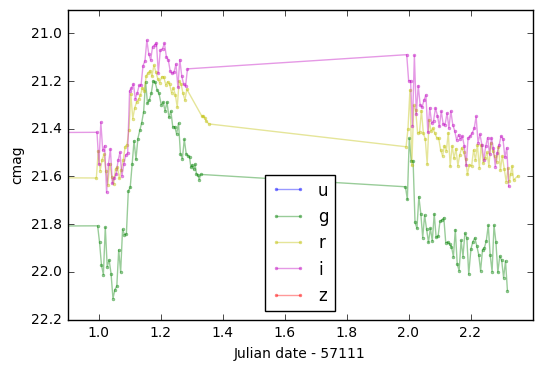

In [12]:
colors = ('b','g','y','m','r')  # define plotting colors
mjd0 = 57111  # zero-point Julian date
for j,filt in enumerate(list('ugriz')):
    sel = (df['filter'] == filt)   # selection: only one filter
    p.plot(df['mjd'][sel]-mjd0,df['cmag'][sel],marker='.',ms=4,ls='-',lw=1,color=colors[j],alpha=0.4,label=filt)

p.xlabel('Julian date - %d' % mjd0)
p.ylabel('cmag')
p.xlim(0.9,2.4)
p.ylim(22.2,20.9)
p.legend(loc='lower center',frameon=True)

In this range of dates there were no u and z-band measurements.